# pubmed

In [31]:
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

def num_tokens_from_string(string, encoding):
    """Returns the number of tokens in a text string."""
    
    try:
        num_tokens = len(encoding.encode(string))
    except:
        num_tokens = 0
    return num_tokens

num_tokens_from_string("tiktoken is great!", encoding)


from dpsda.data_loader import load_data
data_file="data/pubmed/train.csv"
all_private_samples, all_private_labels, private_labels_counter, private_labels_indexer = load_data(
        dataset="pubmed",
        data_file=data_file,
        num_samples=-1,)
from tqdm import tqdm
full_lens=[]
full_words=[]

for i, prompt in enumerate(tqdm(all_private_samples)):
    full_lens.append(num_tokens_from_string(prompt ,encoding))
    full_words.append(len(prompt.split(" ")))



100%|██████████| 75316/75316 [00:19<00:00, 3792.54it/s]


100%|██████████| 2000/2000 [00:00<00:00, 4384.13it/s]


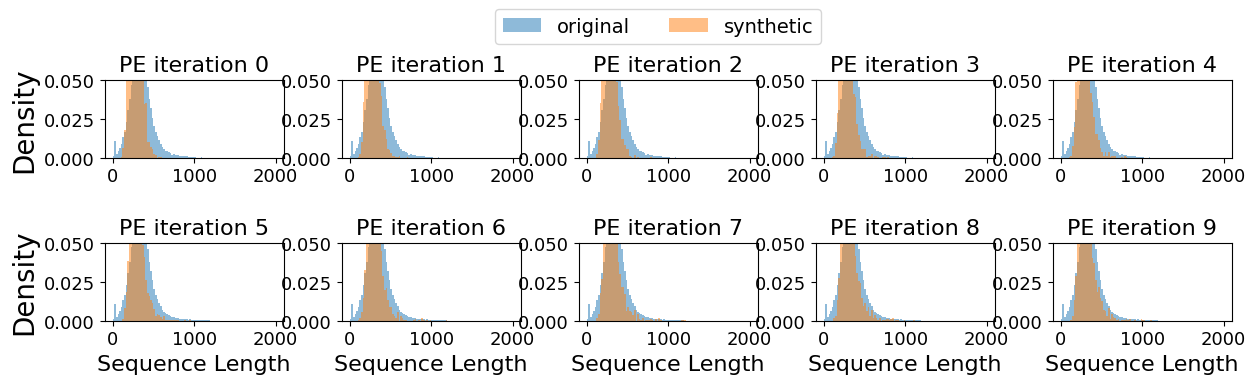

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os 

from datasets import load_dataset



iterations = list(range(10))
fig, ax = plt.subplots(nrows=len(iterations)//5, ncols=5, figsize=(12,3))

fig.tight_layout(h_pad=4)
idx=-1
for row in ax:
    for col in row:
        idx+=1
        if idx >= len(iterations):
            break
        iteration= iterations[idx] 
               
       
        syn_data_file=f"result/pubmed/gpt-3.5-turbo_sentence-t5-base/8000_n0_L4_initL4_var0_pubmed_blank_fill_0_shot_word_rank_len1000var60wo2to5_t1.2/{iteration}/samples.csv"

        if not os.path.isfile(syn_data_file):

            continue 
        _syn_samples =  load_dataset("csv",
                data_files=syn_data_file)

        
        _syn_lens=[]
        for i, prompt in enumerate(tqdm(_syn_samples['train']['text'])):
            _num_token = num_tokens_from_string(prompt ,encoding)
            if _num_token>100:
                _syn_lens.append(_num_token)
        num_bins = 100

      
        x= np.array(full_lens)
        x_w = np.empty(x.shape)
        x_w.fill(1/x.shape[0])

        n, bins, patche = col.hist(full_lens, num_bins, alpha=0.5, weights=x_w,  range=[0, 2000], label = 'original')


          # the histogram of the data
        x= np.array(_syn_lens)
        x_w = np.empty(x.shape)
        x_w.fill(1/x.shape[0])
        _ = col.hist(_syn_lens, num_bins, alpha=0.5, weights=x_w,  range=[0, 2000], label = 'synthetic')


        col.set_ylim([0, 0.05])

        if idx %5==0:
            col.set_ylabel('Density',fontsize=20)
        if idx > 4:
            col.set_xlabel('Sequence Length',fontsize=16)
        
        col.set_title(f'PE iteration {iteration}',fontsize=16)
        col.tick_params(axis='x', labelsize=13)
        col.tick_params(axis='y', labelsize=13)

        handles, labels = col.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4, bbox_to_anchor=(0.5,1.2), fontsize=14)       
plt.savefig("result/plot/pubmed_length_converge.pdf", format="pdf", bbox_inches="tight")
plt.show()